In [111]:
%matplotlib inline
import pdfplumber
from pprint import pprint
import pandas as pd

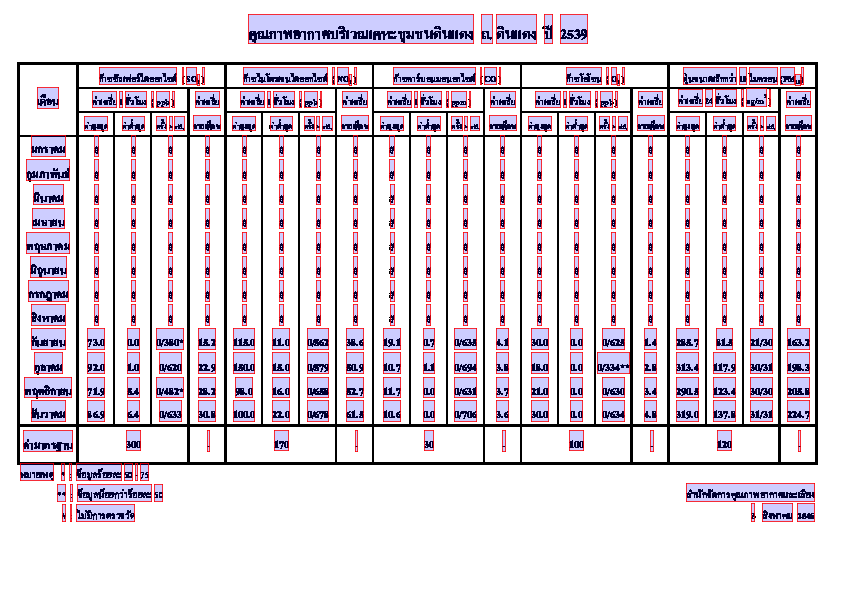

In [87]:
f = '../raw_pdf/54R_1996.pdf'
pdf = pdfplumber.open(f)
first_page = pdf.pages[0]
im = first_page.to_image()
words = first_page.extract_words()
im.draw_rects(words)

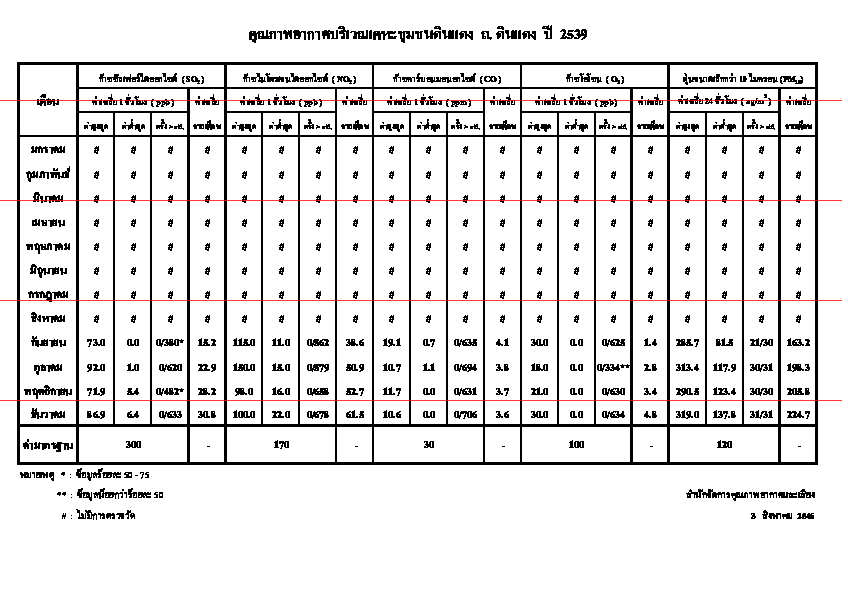

In [88]:
im = first_page.to_image()

im.draw_hlines([100,200,300,400])


In [100]:
def clean_thai(s):
    sub = {
        '\uf702': 'ี',
        '\uf70c': '๊',
        '\uf70e': '์',
        '\uf705': '่',
        '\uf70a': '่'
    }
    tmp = s
    for k, v in sub.items():
        tmp = tmp.replace(k, v)
    return tmp

In [101]:
for prev_word, this_word in zip(words[:-1], words[1:]): # round the line
    if abs(this_word['bottom'] - prev_word['bottom']) < 0.5:
        this_word['bottom'] = prev_word['bottom']
    

12


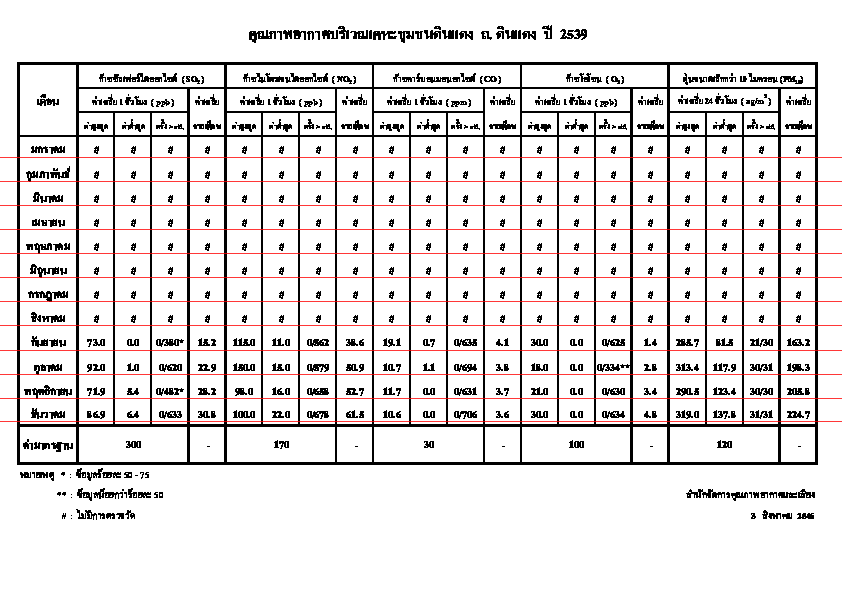

In [102]:
for word in words:
    word['text'] = clean_thai(word['text'])

gas_line = [word['bottom']
            for word in words if word['text'].startswith('ก๊าซ')]


def unique(values):
    tmp = []
    s = set()
    for v in values:
        if v not in s:
            tmp.append(v)
        s.add(v)
    return tmp


col_map = ['high', 'low', 'n_over', 'monthly_avg']
months = [
    'มกราคม',
    'กุมภาพันธ์', 
    'มีนาคม', 
    'เมษายน', 
    'พฤษภาคม', 
    'มิถุนายน', 
    'กรกฎาคม', 
    'สิงหาคม', 
    'กันยายน', 
    'ตุลาคม', 
    'พฤศจิกายน', 
    'ธันวาคม']

months_set = set(months)

months_line = [word['bottom'] for word in words if word['text'] in months_set and word['x0'] < first_page.width/2]

print(len(months_line))
lines = unique([word['bottom'] for word in words])


im = first_page.to_image()

im.draw_hlines(months_line)

In [103]:
def group_by(values, key):
    tmp = {}
    for v in values:
        k = key(v)
        if k not in tmp:
            tmp[k] = []
        tmp[k].append(v)
    return tmp
    

In [104]:
word_by_line = group_by(words, lambda x: x['bottom'])
word_by_line

{Decimal('43.510'): [{'x0': Decimal('248.271'),
   'x1': Decimal('473.925'),
   'top': Decimal('13.694'),
   'bottom': Decimal('43.510'),
   'text': 'คุณภาพอากาศบริเวณเคหะชุมชนดินแดง'},
  {'x0': Decimal('480.951'),
   'x1': Decimal('492.677'),
   'top': Decimal('13.694'),
   'bottom': Decimal('43.510'),
   'text': 'ถ.'},
  {'x0': Decimal('496.191'),
   'x1': Decimal('536.924'),
   'top': Decimal('13.694'),
   'bottom': Decimal('43.510'),
   'text': 'ดินแดง'},
  {'x0': Decimal('543.950'),
   'x1': Decimal('553.221'),
   'top': Decimal('13.694'),
   'bottom': Decimal('43.510'),
   'text': 'ปี'},
  {'x0': Decimal('560.147'),
   'x1': Decimal('587.740'),
   'top': Decimal('13.694'),
   'bottom': Decimal('43.510'),
   'text': '2539'}],
 Decimal('84.554'): [{'x0': Decimal('98.751'),
   'x1': Decimal('177.470'),
   'top': Decimal('66.904'),
   'bottom': Decimal('84.554'),
   'text': 'ก๊าซซัลเฟอร์ไดออกไซด์'},
  {'x0': Decimal('181.579'),
   'x1': Decimal('184.298'),
   'top': Decimal('66.904')

In [109]:
def find_gas_line(word_by_line):
    for h, words in word_by_line.items():
        if words[0]['text'].startswith('ก๊าซ'):
            return h

def find_month_lines(word_by_line):
    tmp = {}
    for h, words in word_by_line.items():
        first_word = words[0]['text']
        if words[0]['text'] in months_set:
            tmp[first_word] = h
    return tmp

def find_year(word_by_line):
    first_line = min(word_by_line.keys())
    for word in word_by_line[first_line]:
        res = re.findall('25\d\d', word['text'])
        if res:
            return res[0]
            
    raise ValueError(f"Can't Find year {first_line}")

gas_line = find_gas_line(word_by_line)
month_lines = find_month_lines(word_by_line)
year = find_year(word_by_line)
assert(len(month_lines)==12)
print(year)
print(month_lines)
print(gas_lines)
def get_gas_names(line):
    tmp = []
    for iw, word in enumerate(line):
        if word['text'].startswith('ก๊าซ'):
            tmp.append(word['text'])
        elif word['text'].startswith('ฝุ่น'):
            tmp.append(word['text']+' '+line[iw+1]['text'])
    return tmp

def get_value(line):
    tmp = []
    for word in line[1:]: # first one is month
        tmp.append(word['text'])
    return tmp
    
gas_names = get_gas_names(word_by_line[gas_line])

all_data = []
for month_name, h in month_lines.items():
    values = get_value(word_by_line[h])
    #print(values, gas_names, len(values))
    assert(len(values) == 4*len(gas_names))
    for igas, gas_name in enumerate(gas_names):
        for icol, col_name in enumerate(col_map):
            ivalue = 4*igas + icol
            value = values[ivalue]
            this_data = {
                'year': year,
                'month': month_name,
                'gas': gas_name,
                'col_name': col_name,
                'value': value
            }
        all_data.append(this_data)
import pandas as pd
df = pd.DataFrame(all_data)


2539
{'มกราคม': Decimal('157.122'), 'กุมภาพันธ์': Decimal('181.243'), 'มีนาคม': Decimal('205.363'), 'เมษายน': Decimal('229.483'), 'พฤษภาคม': Decimal('253.604'), 'มิถุนายน': Decimal('277.724'), 'กรกฎาคม': Decimal('301.844'), 'สิงหาคม': Decimal('325.965'), 'กันยายน': Decimal('350.085'), 'ตุลาคม': Decimal('374.205'), 'พฤศจิกายน': Decimal('398.326'), 'ธันวาคม': Decimal('421.606')}
84.554


In [110]:
df

,year,month,gas,col_name,value
0,2539,มกราคม,ก๊าซซัลเฟอร์ไดออกไซด์,monthly_avg,#
1,2539,มกราคม,ก๊าซไนโตรเจนไดออกไซด์,monthly_avg,#
2,2539,มกราคม,ก๊าซคาร์บอนมอนอกไซด์,monthly_avg,#
3,2539,มกราคม,ก๊าซโอโซน,monthly_avg,#
4,2539,มกราคม,ฝุ่นขนาดเล็กกว่า 10,monthly_avg,#
5,2539,กุมภาพันธ์,ก๊าซซัลเฟอร์ไดออกไซด์,monthly_avg,#
6,2539,กุมภาพันธ์,ก๊าซไนโตรเจนไดออกไซด์,monthly_avg,#
7,2539,กุมภาพันธ์,ก๊าซคาร์บอนมอนอกไซด์,monthly_avg,#
8,2539,กุมภาพันธ์,ก๊าซโอโซน,monthly_avg,#
9,2539,กุมภาพันธ์,ฝุ่นขนาดเล็กกว่า 10,monthly_avg,#


In [84]:
word_by_line[gas_line]

[{'x0': Decimal('98.751'),
  'x1': Decimal('177.470'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'ก๊าซซัลเฟอร์ไดออกไซด์'},
 {'x0': Decimal('181.579'),
  'x1': Decimal('184.298'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': '('},
 {'x0': Decimal('186.352'),
  'x1': Decimal('197.229'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'SO'},
 {'x0': Decimal('202.070'),
  'x1': Decimal('204.789'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': ')'},
 {'x0': Decimal('242.631'),
  'x1': Decimal('327.950'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'ก๊าซไนโตรเจนไดออกไซด์'},
 {'x0': Decimal('332.059'),
  'x1': Decimal('334.778'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': '('},
 {'x0': Decimal('336.832'),
  'x1': Decimal('349.069'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'NO'},
 {'x0': Decimal('353.870'),
  'x1': Decima

In [72]:
word_by_line[gas_line]

[{'x0': Decimal('98.751'),
  'x1': Decimal('177.470'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'ก๊าซซัลเฟอร์ไดออกไซด์'},
 {'x0': Decimal('181.579'),
  'x1': Decimal('184.298'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': '('},
 {'x0': Decimal('186.352'),
  'x1': Decimal('197.229'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'SO'},
 {'x0': Decimal('202.070'),
  'x1': Decimal('204.789'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': ')'},
 {'x0': Decimal('242.631'),
  'x1': Decimal('327.950'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'ก๊าซไนโตรเจนไดออกไซด์'},
 {'x0': Decimal('332.059'),
  'x1': Decimal('334.778'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': '('},
 {'x0': Decimal('336.832'),
  'x1': Decimal('349.069'),
  'top': Decimal('66.904'),
  'bottom': Decimal('84.554'),
  'text': 'NO'},
 {'x0': Decimal('353.870'),
  'x1': Decima

In [22]:
im = my_pdf.pages[0].to_image(resolution=150)

NameError: name 'my_pdf' is not defined

In [48]:
import re

In [52]:
re.findall('25\d\d', 'ปี 2539')

['2539']